<a href="https://colab.research.google.com/github/Davenzy/audio_generation/blob/main/audio_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21

!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
from music21 import *

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [ ]:
# Импортируем библиотеки
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.optimizers import Adamax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip

# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset

--2024-08-31 07:27:19--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  6.62MB/s    in 0.4s    

2024-08-31 07:27:20 (6.62 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]



In [ ]:
CLASS_LIST = ["Chopin", "Mozart"]

all_midis = {}

for compositor in CLASS_LIST:
    all_midis[compositor] = []
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i

            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis[compositor].append(midi)

In [ ]:
def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [ ]:
Corpus_train = getNotes(all_midis['Chopin'])
Corpus_seed = getNotes(all_midis['Mozart'])

print("Всего нот во всех midi-файлах тренировачного датасета:", len(Corpus_train))
print("Всего нот во всех midi-файлах тестового датасета:", len(Corpus_seed))

Всего нот во всех midi-файлах тренировачного датасета: 57894
Всего нот во всех midi-файлах тестового датасета: 55802


In [ ]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1


    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(Corpus_train[:100])
Melody_midi = stream.Stream(Music)

In [ ]:
from collections import Counter
count_num_train = Counter(Corpus_train)
count_num_seed = Counter(Corpus_seed)
print("Общее число уникальных нот в корпусе:", len(count_num_train))
print("Общее число уникальных нот в корпусе:", len(count_num_seed))

Общее число уникальных нот в корпусе: 397
Общее число уникальных нот в корпусе: 229


In [ ]:
# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes_train = list(count_num_train.keys())
Recurrence_train = list(count_num_train.values())

Notes_seed = list(count_num_seed.keys())
Recurrence_seed = list(count_num_seed.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence_train))
print('Наиболее часто встречаемые ноты:', max(Recurrence_train), 'раз')
print('Наиболее редкие ноты:', min(Recurrence_train), 'раз')

Средняя повторяемость ноты: 145.8287153652393
Наиболее часто встречаемые ноты: 1627 раз
Наиболее редкие ноты: 1 раз


In [ ]:
# Получение списка редких нот
def count_rare_note(count_num):
  rare_note = []
  for index, (key, value) in enumerate(count_num.items()):
      if value < 100:
          m =  key
          rare_note.append(m)
  return rare_note

rare_note_train = count_rare_note(count_num_train)
rare_note_seed = count_rare_note(count_num_seed)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note_train))
print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note_seed))

Общее число нот, которые повторяются менее 100 раз: 270
Общее число нот, которые повторяются менее 100 раз: 145


In [ ]:
def rm_rare_note(Corpus, rare_note):
  for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

  print("Длина корпуса после исключения редких нот:", len(Corpus))

  return Corpus

In [ ]:
Corpus_train = rm_rare_note(Corpus_train, rare_note_train)
Corpus_seed = rm_rare_note(Corpus_seed, rare_note_seed)

Длина корпуса после исключения редких нот: 53752
Длина корпуса после исключения редких нот: 53135


In [ ]:
# Сохраняем все уникальные значения корпуса
symb_train = sorted(list(set(Corpus_train)))
symb_seed = sorted(list(set(Corpus_seed)))

L_corpus_train = len(Corpus_train) # длина корпуса
L_symb_train = len(symb_train) # число уникальных элементов корпуса

L_corpus_seed = len(Corpus_seed) # длина корпуса
L_symb_seed = len(symb_seed)

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb_train))
mapping_seed = dict((c, i) for i, c in enumerate(symb_seed))
reverse_mapping = dict((i, c) for i, c in enumerate(symb_train))

print("Общее число символов:", L_corpus_train)
print("Число уникальных символов:", L_symb_train)

Общее число символов: 53752
Число уникальных символов: 263


In [ ]:
# Разбиение корпуса на равные входные строки и выходные целевые последовательности

# длинны последовательностей
length = 40

# цикл разбиения корпуса
def body_split(L_corpus, Corpus, length, mapping):
  features, targets = [], []
  for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
  return features, targets


features_train, targets_train = body_split(L_corpus_train, Corpus_train, length, mapping)
features_seed, targets_seed = body_split(L_corpus_seed, Corpus_seed, length, mapping_seed)

L_datapoints_train = len(targets_train)
L_datapoints_seed = len(targets_seed)
print("Общее количество последовательностей в корпусе:", L_datapoints_train)

Общее количество последовательностей в корпусе: 53712


In [ ]:
# изменение размера и нормализация входных данных
X_train = (np.reshape(features_train, (L_datapoints_train, length, 1)))/ float(L_symb_train)
X_seed = (np.reshape(features_seed, (L_datapoints_seed, length, 1)))/ float(L_symb_seed)

# one-hot encode для целевых выходных данных
y_train = tensorflow.keras.utils.to_categorical(targets_train)

In [ ]:
print(f'Форма входных данных: {X_train.shape}')
print(f'Форма входных данных: {y_train.shape}')
print(f'Форма выходных данных: {X_seed.shape}')

Форма входных данных: (53712, 40, 1)
Форма входных данных: (53712, 263)
Форма выходных данных: (53095, 40, 1)


In [ ]:
model = Sequential()

model.add(LSTM(256, input_shape=X_train.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 40, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 40, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 263)                 │          33,927 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 511,751 (1.95 MB)

 Trainable params: 511,751 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=150)

Epoch 1/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - acc: 0.0227 - loss: 4.8598
Epoch 2/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - acc: 0.0268 - loss: 4.6826
Epoch 3/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - acc: 0.0353 - loss: 4.5202
Epoch 4/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - acc: 0.0360 - loss: 4.4427
Epoch 5/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.0374 - loss: 4.4372
Epoch 6/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.0382 - loss: 4.4292
Epoch 7/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - acc: 0.0397 - loss: 4.4109
Epoch 8/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - acc: 0.0402 - loss: 4.4063
Epoch 9/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.0388 - loss: 4.3909
Epoch 10/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - acc: 0.0403 - loss: 4.3860
Epoch 11/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.0427 - loss: 4.3623
Epoch 12/150
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.0413 - loss: 4.3551
E

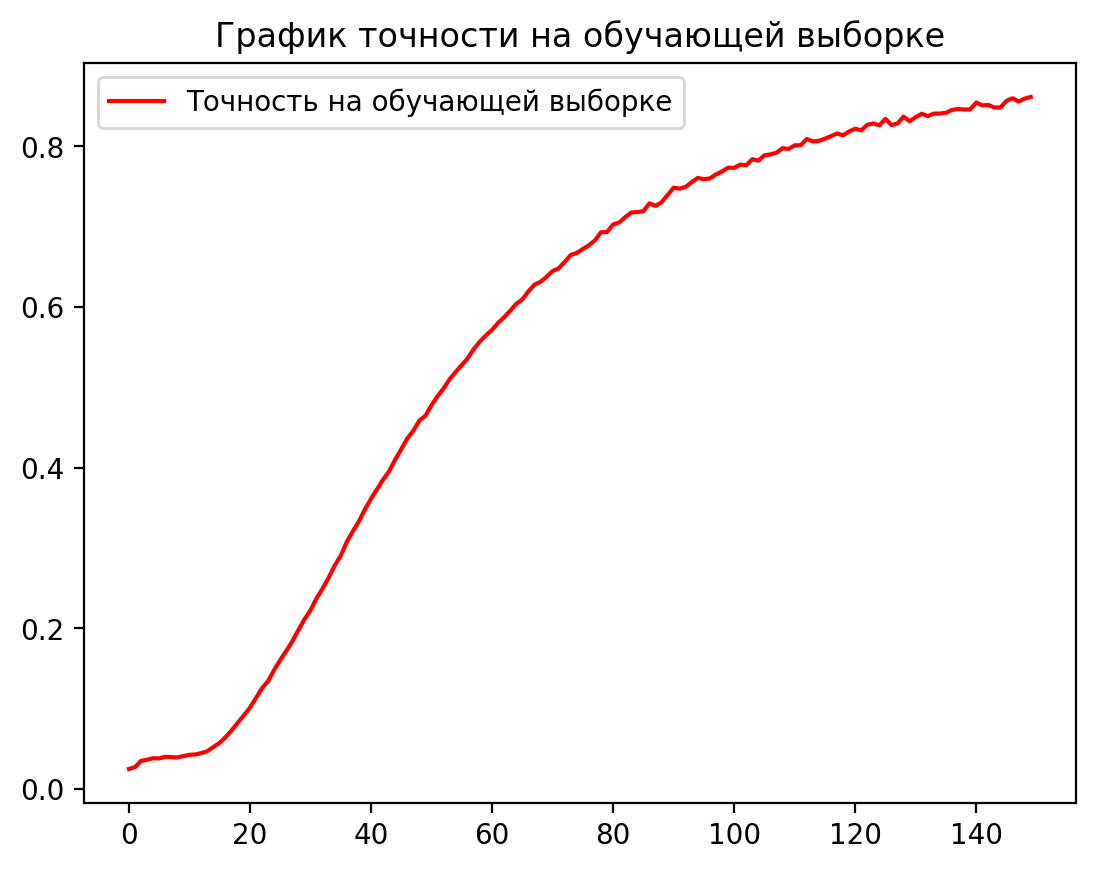

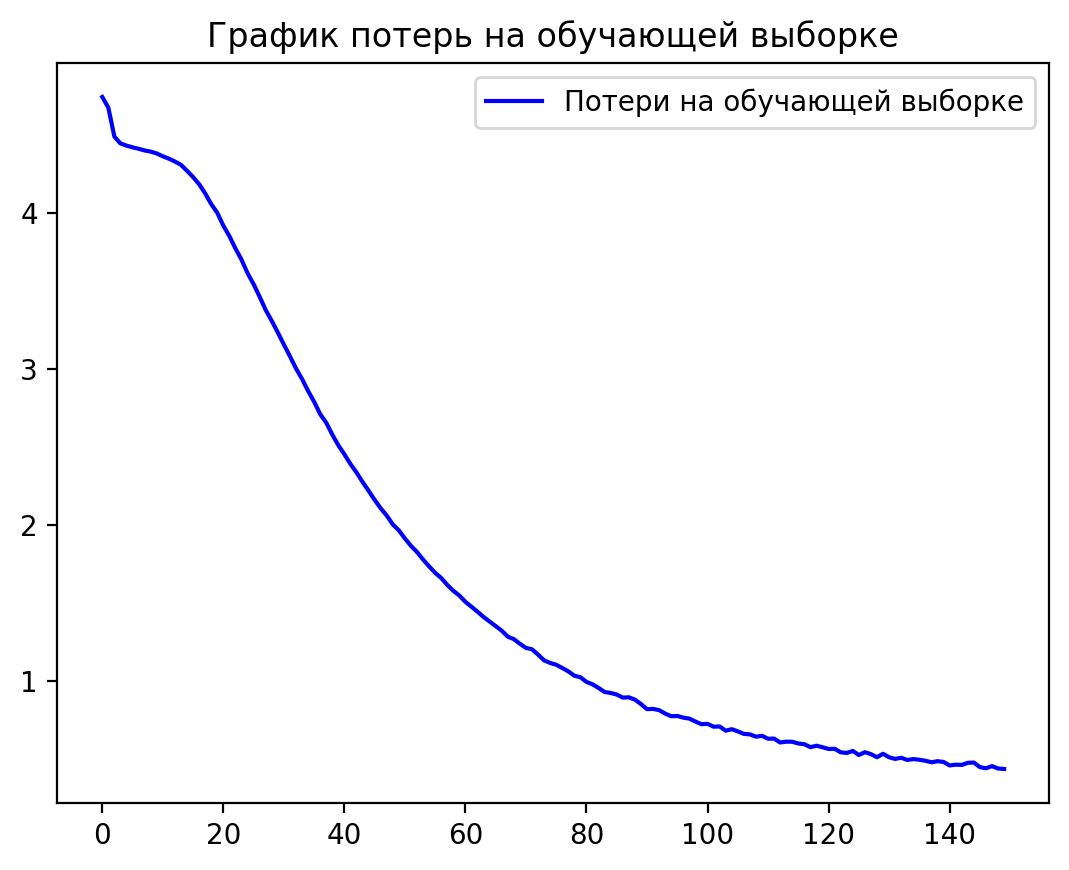

In [ ]:
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

In [ ]:
def music_generator(seq_len):
    # случайный выбор начальной последовательности
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]

        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb_test)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)


In [ ]:
genMusic = music_generator(100)
genMidi = stream.Stream(genMusic)

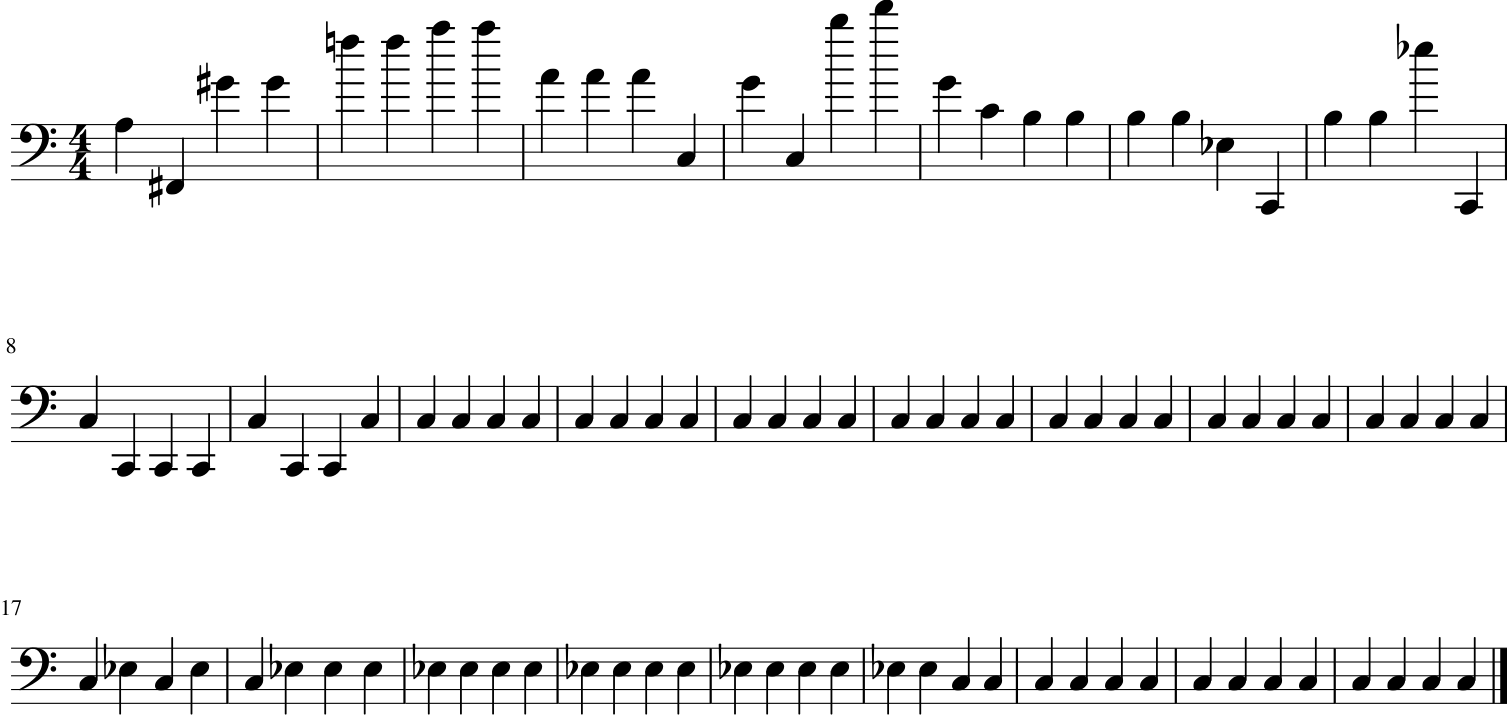

In [ ]:
# Отобразим нотный стан
genMidi.show()

In [ ]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')